# Calorie Burn Predictions - XGBoost Model
This notebook is dedicated to fine tuning an XGBoost model to see if it can perform better than our current ensemble model.

## Packages

In [ ]:
# Data Science Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modelling Functions
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

import time

## Functions

In [2]:
# Root Mean Squared Logarithmic Error
def RMSLE(actual, prediction):
    """
    A function that takes two input arrays and returns the Root Mean Squared Logarithmic Error (RMSLE).
    
    Parameters
    ----------
    actual : array-like
        The true values.

    prediction : array-like
        The predictions.
    
    Returns
    -------
    float
        The RMSLE.
    """

    # Ensure inputs are numpy arrays
    try:
        actual = np.asarray(actual)
        prediction = np.asarray(prediction)
    except:
        raise TypeError('Could not convert the inputs to arrays.')

    # Check whether the arrays are of equal lengths
    if len(actual) != len(prediction):
        raise ValueError('The two input arrays must be of equal length.')
    
    # Ensure all the numbers in the arrays are non-negative
    if (actual<0).any() or (prediction<0).any():
        raise ValueError('The true values and predictions must both be non-negative.')

    # Return the RMSLE
    return float( np.sqrt( np.mean( (np.log(1+prediction) - np.log(1+actual)) ** 2 ) ) )

# Non-Negativity Criteria
def non_negative(array):
    """
    A function to ensure that all predictions are non-negative. 

    Parameters
    ----------
    array : array-like
        An array containing prediction values.
    
    Returns
    -------
    array-like
        An array containing non-negative predictions.
    """
    return np.clip(array, 0.0, None)

def custom_scoring_func(estimator, X, y):
    """
    A function to use in RandomSearchCV and GridSearchCV to find the best parameter combinations to minimize the RMSLE score.

    Parameters
    ----------
    estimator: model object
        The model object itself.
    X: array-like
        An array containing the input features.
    y: array-like
        An array containing the actual values.

    Returns
    -------
    float
        The negative RMSLE score when it is maximized in RandomizedSearchCV or GridSearchCV.
    """
    prediction = estimator.predict(X)
    prediction = non_negative(prediction)
    return -RMSLE(y, prediction)

## Reading

In [3]:
train = pd.read_csv('Data/train.csv', index_col='id')
train.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
id,,,,,,,,
0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,female,38,166.0,61.0,25.0,102.0,40.6,146.0


In [4]:
test = pd.read_csv('Data/test.csv', index_col='id')
test.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
id,,,,,,,
750000,male,45,177.0,81.0,7.0,87.0,39.8
750001,male,26,200.0,97.0,20.0,101.0,40.5
750002,female,29,188.0,85.0,16.0,102.0,40.4
750003,female,39,172.0,73.0,20.0,107.0,40.6
750004,female,30,173.0,67.0,16.0,94.0,40.5


## Feature Engineering
Features created in the exploration notebook are recreated here, along with a calorie burn per minute feature to detect any outliers.

In [5]:
# Male indicator variable
train['Male'] = (train['Sex'] == 'male').astype(int)

# Senior indicator variable
train['Senior'] = (train['Age'] >= 60).astype(int)

# Body Mass Index (BMI)
train['BMI'] = train['Weight'] / (train['Height']/100)**2

# Maximum Heart Rate
train['max_HR'] = 208 - 0.7 * train['Age']

# Relative Intensity: Heart Rate / Estimated Maximum Heart Rate
train['Relative_Intensity'] = train['Heart_Rate'] / train['max_HR']

# Calories per Minute --> Done to identify potential outliers
train['Calories_per_min'] = train['Calories'] / train['Duration']

# Reorder the columns into a sensible order and to have the target on the end
train = train[['Sex', 'Male', 'Age', 'Senior', 'Weight', 'Height', 'BMI', 'max_HR', 'Heart_Rate', 'Relative_Intensity', 'Body_Temp', 'Duration', 'Calories', 'Calories_per_min']]
train.head()

,Sex,Male,Age,Senior,Weight,Height,BMI,max_HR,Heart_Rate,Relative_Intensity,Body_Temp,Duration,Calories,Calories_per_min
id,,,,,,,,,,,,,,
0,male,1,36,0,82.0,189.0,22.955684,182.8,101.0,0.552516,41.0,26.0,150.0,5.769231
1,female,0,64,1,60.0,163.0,22.582709,163.2,85.0,0.520833,39.7,8.0,34.0,4.250000
2,female,0,51,0,64.0,161.0,24.690405,172.3,84.0,0.487522,39.8,7.0,29.0,4.142857
3,male,1,20,0,90.0,192.0,24.414062,194.0,105.0,0.541237,40.7,25.0,140.0,5.600000
4,female,0,38,0,61.0,166.0,22.136740,181.4,102.0,0.562293,40.6,25.0,146.0,5.840000


In [6]:
# Male indicator variable
test['Male'] = (test['Sex'] == 'male').astype(int)

# Senior indicator variable
test['Senior'] = (test['Age'] >= 60).astype(int)

# Body Mass Index (BMI)
test['BMI'] = test['Weight'] / (test['Height']/100)**2

# Maximum Heart Rate
test['max_HR'] = 208 - 0.7 * test['Age']

# Relative Intensity: Heart Rate / Estimated Maximum Heart Rate
test['Relative_Intensity'] = test['Heart_Rate'] / test['max_HR']

# Reorder the columns into a sensible order
test = test[['Sex', 'Male', 'Age', 'Senior', 'Weight', 'Height', 'BMI', 'max_HR', 'Heart_Rate', 'Relative_Intensity', 'Body_Temp', 'Duration']]
test.head()

,Sex,Male,Age,Senior,Weight,Height,BMI,max_HR,Heart_Rate,Relative_Intensity,Body_Temp,Duration
id,,,,,,,,,,,,
750000,male,1,45,0,81.0,177.0,25.854639,176.5,87.0,0.492918,39.8,7.0
750001,male,1,26,0,97.0,200.0,24.250000,189.8,101.0,0.532139,40.5,20.0
750002,female,0,29,0,85.0,188.0,24.049344,187.7,102.0,0.543420,40.4,16.0
750003,female,0,39,0,73.0,172.0,24.675500,180.7,107.0,0.592142,40.6,20.0
750004,female,0,30,0,67.0,173.0,22.386314,187.0,94.0,0.502674,40.5,16.0


## Interactions

In [7]:
## Two-Way Interactions
# Time Interactions
train['Duration*Age'] = train['Duration']*train['Age']
train['Duration*Weight'] = train['Duration']*train['Weight']
train['Duration*Relative_Intensity'] = train['Duration']*train['Relative_Intensity']
train['Duration*Heart_Rate'] = train['Duration']*train['Heart_Rate']
train['Duration*Body_Temp'] = train['Duration']*train['Body_Temp']

# Intensity Interactions
train['Relative_Intensity*Age'] = train['Relative_Intensity']*train['Age']
train['Relative_Intensity*Weight'] = train['Relative_Intensity']*train['Weight']
train['Relative_Intensity*Body_Temp'] = train['Relative_Intensity']*train['Body_Temp']

# Age Interactions
train['Age*Heart_Rate'] = train['Age']*train['Heart_Rate']
train['Senior*Male'] = train['Senior']*train['Male']
train['Age*Body_Temp'] = train['Age']*train['Body_Temp']

# Weight Interaction
train['Weight*Heart_Rate'] = train['Weight']*train['Heart_Rate']
train['Weight*Body_Temp'] = train['Weight']*train['Body_Temp']

## Three-Way Interactions
train['Age*Weight*Duration'] = train['Age']*train['Weight']*train['Duration']
train['Weight*Duration*Relative_Intensity'] = train['Weight']*train['Duration']*train['Relative_Intensity']

## Four-Way Interactions
train['Age*Weight*Duration*Relative_Intensity'] = train['Age']*train['Weight']*train['Duration']*train['Relative_Intensity']

train.head()

,Sex,Male,Age,Senior,Weight,Height,BMI,max_HR,Heart_Rate,Relative_Intensity,...,Relative_Intensity*Weight,Relative_Intensity*Body_Temp,Age*Heart_Rate,Senior*Male,Age*Body_Temp,Weight*Heart_Rate,Weight*Body_Temp,Age*Weight*Duration,Weight*Duration*Relative_Intensity,Age*Weight*Duration*Relative_Intensity
id,,,,,,,,,,,,,,,,,,,,,
0,male,1,36,0,82.0,189.0,22.955684,182.8,101.0,0.552516,...,45.306346,22.653173,3636.0,0,1476.0,8282.0,3362.0,76752.0,1177.964989,42406.739606
1,female,0,64,1,60.0,163.0,22.582709,163.2,85.0,0.520833,...,31.250000,20.677083,5440.0,0,2540.8,5100.0,2382.0,30720.0,250.000000,16000.000000
2,female,0,51,0,64.0,161.0,24.690405,172.3,84.0,0.487522,...,31.201393,19.403366,4284.0,0,2029.8,5376.0,2547.2,22848.0,218.409750,11138.897272
3,male,1,20,0,90.0,192.0,24.414062,194.0,105.0,0.541237,...,48.711340,22.028351,2100.0,0,814.0,9450.0,3663.0,45000.0,1217.783505,24355.670103
4,female,0,38,0,61.0,166.0,22.136740,181.4,102.0,0.562293,...,34.299890,22.829107,3876.0,0,1542.8,6222.0,2476.6,57950.0,857.497244,32584.895259


In [8]:
## Two-Way Interactions
# Time Interactions
test['Duration*Age'] = test['Duration']*test['Age']
test['Duration*Weight'] = test['Duration']*test['Weight']
test['Duration*Relative_Intensity'] = test['Duration']*test['Relative_Intensity']
test['Duration*Heart_Rate'] = test['Duration']*test['Heart_Rate']
test['Duration*Body_Temp'] = test['Duration']*test['Body_Temp']

# Intensity Interactions
test['Relative_Intensity*Age'] = test['Relative_Intensity']*test['Age']
test['Relative_Intensity*Weight'] = test['Relative_Intensity']*test['Weight']
test['Relative_Intensity*Body_Temp'] = test['Relative_Intensity']*test['Body_Temp']

# Age Interactions
test['Age*Heart_Rate'] = test['Age']*test['Heart_Rate']
test['Senior*Male'] = test['Senior']*test['Male']
test['Age*Body_Temp'] = test['Age']*test['Body_Temp']

# Weight Interaction
test['Weight*Heart_Rate'] = test['Weight']*test['Heart_Rate']
test['Weight*Body_Temp'] = test['Weight']*test['Body_Temp']

## Three-Way Interactions
test['Age*Weight*Duration'] = test['Age']*test['Weight']*test['Duration']
test['Weight*Duration*Relative_Intensity'] = test['Weight']*test['Duration']*test['Relative_Intensity']

## Four-Way Interactions
test['Age*Weight*Duration*Relative_Intensity'] = test['Age']*test['Weight']*test['Duration']*test['Relative_Intensity']

test.head()

,Sex,Male,Age,Senior,Weight,Height,BMI,max_HR,Heart_Rate,Relative_Intensity,...,Relative_Intensity*Weight,Relative_Intensity*Body_Temp,Age*Heart_Rate,Senior*Male,Age*Body_Temp,Weight*Heart_Rate,Weight*Body_Temp,Age*Weight*Duration,Weight*Duration*Relative_Intensity,Age*Weight*Duration*Relative_Intensity
id,,,,,,,,,,,,,,,,,,,,,
750000,male,1,45,0,81.0,177.0,25.854639,176.5,87.0,0.492918,...,39.926346,19.618130,3915.0,0,1791.0,7047.0,3223.8,25515.0,279.484419,12576.798867
750001,male,1,26,0,97.0,200.0,24.250000,189.8,101.0,0.532139,...,51.617492,21.551633,2626.0,0,1053.0,9797.0,3928.5,50440.0,1032.349842,26841.095890
750002,female,0,29,0,85.0,188.0,24.049344,187.7,102.0,0.543420,...,46.190730,21.954182,2958.0,0,1171.6,8670.0,3434.0,39440.0,739.051678,21432.498668
750003,female,0,39,0,73.0,172.0,24.675500,180.7,107.0,0.592142,...,43.226342,24.040952,4173.0,0,1583.4,7811.0,2963.8,56940.0,864.526840,33716.546763
750004,female,0,30,0,67.0,173.0,22.386314,187.0,94.0,0.502674,...,33.679144,20.358289,2820.0,0,1215.0,6298.0,2713.5,32160.0,538.866310,16165.989305


In [9]:
interactions = ['Duration*Age', 'Duration*Weight', 'Duration*Relative_Intensity', 'Duration*Heart_Rate', 'Duration*Body_Temp', 
                 'Relative_Intensity*Age', 'Relative_Intensity*Weight', 'Relative_Intensity*Body_Temp', 
                 'Age*Heart_Rate', 'Senior*Male', 'Age*Body_Temp', 'Weight*Heart_Rate', 'Weight*Body_Temp', 
                 'Age*Weight*Duration', 'Weight*Duration*Relative_Intensity', 
                 'Age*Weight*Duration*Relative_Intensity']

## Outlier Removal

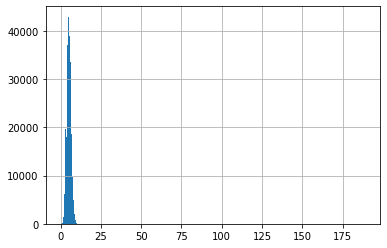

count    750000.000000
mean          5.145520
std           1.438803
min           0.115385
25%           4.200000
50%           5.125000
75%           6.050000
max         189.000000
Name: Calories_per_min, dtype: float64

In [10]:
# Show the distribution of calories per minute
train['Calories_per_min'].hist(bins=1000)
plt.show()
train['Calories_per_min'].describe()

In [11]:
# Remove outliers based on exercise physiology limitations
lower_bound = 1.0 # Resting calorie burn is around 1.0 calories per minute
upper_bound = 15.0 # Most people can burn up to 15 calories per minute; sometimes even more in exceptional cases

# Filter to keep only acceptable values
train = train[ (train['Calories_per_min'] >= lower_bound) & (train['Calories_per_min'] <= upper_bound)]
train.head()

,Sex,Male,Age,Senior,Weight,Height,BMI,max_HR,Heart_Rate,Relative_Intensity,...,Relative_Intensity*Weight,Relative_Intensity*Body_Temp,Age*Heart_Rate,Senior*Male,Age*Body_Temp,Weight*Heart_Rate,Weight*Body_Temp,Age*Weight*Duration,Weight*Duration*Relative_Intensity,Age*Weight*Duration*Relative_Intensity
id,,,,,,,,,,,,,,,,,,,,,
0,male,1,36,0,82.0,189.0,22.955684,182.8,101.0,0.552516,...,45.306346,22.653173,3636.0,0,1476.0,8282.0,3362.0,76752.0,1177.964989,42406.739606
1,female,0,64,1,60.0,163.0,22.582709,163.2,85.0,0.520833,...,31.250000,20.677083,5440.0,0,2540.8,5100.0,2382.0,30720.0,250.000000,16000.000000
2,female,0,51,0,64.0,161.0,24.690405,172.3,84.0,0.487522,...,31.201393,19.403366,4284.0,0,2029.8,5376.0,2547.2,22848.0,218.409750,11138.897272
3,male,1,20,0,90.0,192.0,24.414062,194.0,105.0,0.541237,...,48.711340,22.028351,2100.0,0,814.0,9450.0,3663.0,45000.0,1217.783505,24355.670103
4,female,0,38,0,61.0,166.0,22.136740,181.4,102.0,0.562293,...,34.299890,22.829107,3876.0,0,1542.8,6222.0,2476.6,57950.0,857.497244,32584.895259


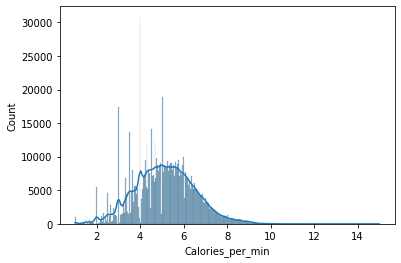

count    749773.000000
mean          5.143369
std           1.369626
min           1.000000
25%           4.200000
50%           5.125000
75%           6.050000
max          15.000000
Name: Calories_per_min, dtype: float64

In [12]:
# Show the new distribution of calories per minute without any outliers
sns.histplot(train['Calories_per_min'], kde=True)
plt.show()
train['Calories_per_min'].describe()

## Model Preparation

In [13]:
# Preparing Inputs
features = ['Male', 'Age', 'Senior', 'Weight', 'Height', 'BMI', 'Heart_Rate', 'Relative_Intensity', 'Body_Temp', 'Duration'] + interactions
target = 'Calories'

# Training Data
X_train = train[features]
y_train = train[target]

# Test Data
X_test = test[features]

# XBGoost Random Seed
seed = 346

# Search Random Seed
search_seed = 56856

# Modelling Data
model_fitting_data = pd.concat([X_train, y_train], axis=1)
model_fitting_data.head()

,Male,Age,Senior,Weight,Height,BMI,Heart_Rate,Relative_Intensity,Body_Temp,Duration,...,Relative_Intensity*Body_Temp,Age*Heart_Rate,Senior*Male,Age*Body_Temp,Weight*Heart_Rate,Weight*Body_Temp,Age*Weight*Duration,Weight*Duration*Relative_Intensity,Age*Weight*Duration*Relative_Intensity,Calories
id,,,,,,,,,,,,,,,,,,,,,
0,1,36,0,82.0,189.0,22.955684,101.0,0.552516,41.0,26.0,...,22.653173,3636.0,0,1476.0,8282.0,3362.0,76752.0,1177.964989,42406.739606,150.0
1,0,64,1,60.0,163.0,22.582709,85.0,0.520833,39.7,8.0,...,20.677083,5440.0,0,2540.8,5100.0,2382.0,30720.0,250.000000,16000.000000,34.0
2,0,51,0,64.0,161.0,24.690405,84.0,0.487522,39.8,7.0,...,19.403366,4284.0,0,2029.8,5376.0,2547.2,22848.0,218.409750,11138.897272,29.0
3,1,20,0,90.0,192.0,24.414062,105.0,0.541237,40.7,25.0,...,22.028351,2100.0,0,814.0,9450.0,3663.0,45000.0,1217.783505,24355.670103,140.0
4,0,38,0,61.0,166.0,22.136740,102.0,0.562293,40.6,25.0,...,22.829107,3876.0,0,1542.8,6222.0,2476.6,57950.0,857.497244,32584.895259,146.0


## Model Tuning
We will start by using RandomizedSearchCV to find which hyperparameters are likely around the best combination, then we will use GridSearchCV twice to find which parameters are truly the best.

In [14]:
# Tune the models on a subset of the data to reduce computation time - small sample for Randomized Search
model_tuning_data = model_fitting_data.sample(n=100000, random_state=345)
X_tune = model_tuning_data[features]
y_tune = model_tuning_data[target]
model_tuning_data.head()

,Male,Age,Senior,Weight,Height,BMI,Heart_Rate,Relative_Intensity,Body_Temp,Duration,...,Relative_Intensity*Body_Temp,Age*Heart_Rate,Senior*Male,Age*Body_Temp,Weight*Heart_Rate,Weight*Body_Temp,Age*Weight*Duration,Weight*Duration*Relative_Intensity,Age*Weight*Duration*Relative_Intensity,Calories
id,,,,,,,,,,,,,,,,,,,,,
619237,1,52,0,102.0,201.0,25.246900,99.0,0.576923,40.9,21.0,...,23.596154,5148.0,0,2126.8,10098.0,4171.8,111384.0,1235.769231,64260.000000,135.0
269723,1,37,0,94.0,192.0,25.499132,93.0,0.510708,40.1,18.0,...,20.479407,3441.0,0,1483.7,8742.0,3769.4,62604.0,864.118616,31972.388797,83.0
163428,0,68,1,60.0,156.0,24.654832,88.0,0.548628,40.7,16.0,...,22.329177,5984.0,0,2767.6,5280.0,2442.0,65280.0,526.683292,35814.463840,74.0
434964,0,24,0,52.0,147.0,24.064047,92.0,0.481172,40.2,13.0,...,19.343096,2208.0,0,964.8,4784.0,2090.4,16224.0,325.271967,7806.527197,60.0
180761,0,32,0,71.0,179.0,22.159109,90.0,0.484914,40.1,14.0,...,19.445043,2880.0,0,1283.2,6390.0,2847.1,31808.0,482.004310,15424.137931,60.0


### Randomized Search
5 minutes

In [15]:
# Paramaters to try
param_distributions = {
    'n_estimators': [100, 300, 500, 700, 1000],
    'max_depth': [3, 5, 8, 10, 15],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'min_child_weight': [1.0, 10.0],
    'subsample': [1.0],
    'colsample_bytree': [1.0]
}

# Use RandomizedSearchCV() to find likely best parameters
random_search = RandomizedSearchCV(
    estimator = XGBRegressor(objective='reg:squarederror', tree_method='hist', random_state=seed),
    param_distributions = param_distributions,
    n_iter=30,
    cv=5,
    n_jobs=16, # Use an appropriate number of cores for the machine
    scoring=custom_scoring_func,
    verbose=2,
    random_state=search_seed
)

start = time.time() # Start Runtime Timer

# Fit the model to the training data
random_search.fit(X_tune, y_tune)

end = time.time() # End Runtime Timer

# Print Hyperparameter Tuning Results
print('\nXGBoost Hyperparameter Tuning')
print('-----------------------------')
print(f'Runtime: {(end-start)/60:.2f} minutes')
print('Parameter Tuning Results:')
for parameter, result in random_search.best_params_.items():
    print(f'\t-{parameter}: {result}')

# Save the best parameters
best_params_RandomizedSearch = random_search.best_params_

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=1.0, n_estimators=100, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=1.0, n_estimators=100, subsample=1.0; total time=   2.4s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=1.0, n_estimators=100, subsample=1.0; total time=   2.9s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=1.0, n_estimators=100, subsample=1.0; total time=   3.5s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=1.0, n_estimators=100, subsample=1.0; total time=   3.5s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1.0, n_estimators=700, subsample=1.0; total time=   4.6s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1.0, n_estimators=700, subsampl

**Parameter Tuning Results**
- n_estimators: 1000
- max_depth: 8
- learning_rate: 0.03
- min_child_weight: 10.0
- colsample_bytree: 1.0
- subsample: 1.0

In [16]:
# View the top 5 results
pd.set_option('display.max_colwidth', None) # Set wider column display
randomized_search_df = pd.DataFrame(random_search.cv_results_)[['params', 'mean_test_score', 'std_test_score']].sort_values(by='mean_test_score', ascending=False)
randomized_search_df.head(10)

,params,mean_test_score,std_test_score
7,"{'subsample': 1.0, 'n_estimators': 1000, 'min_child_weight': 10.0, 'max_depth': 8, 'learning_rate': 0.03, 'colsample_bytree': 1.0}",-0.057956,0.000823
21,"{'subsample': 1.0, 'n_estimators': 300, 'min_child_weight': 10.0, 'max_depth': 8, 'learning_rate': 0.05, 'colsample_bytree': 1.0}",-0.057991,0.000894
27,"{'subsample': 1.0, 'n_estimators': 300, 'min_child_weight': 10.0, 'max_depth': 10, 'learning_rate': 0.05, 'colsample_bytree': 1.0}",-0.058060,0.000777
12,"{'subsample': 1.0, 'n_estimators': 500, 'min_child_weight': 10.0, 'max_depth': 10, 'learning_rate': 0.05, 'colsample_bytree': 1.0}",-0.058116,0.000795
20,"{'subsample': 1.0, 'n_estimators': 300, 'min_child_weight': 10.0, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 1.0}",-0.058458,0.000845
16,"{'subsample': 1.0, 'n_estimators': 1000, 'min_child_weight': 1.0, 'max_depth': 10, 'learning_rate': 0.01, 'colsample_bytree': 1.0}",-0.058497,0.000660
2,"{'subsample': 1.0, 'n_estimators': 1000, 'min_child_weight': 10.0, 'max_depth': 10, 'learning_rate': 0.05, 'colsample_bytree': 1.0}",-0.058498,0.000724
29,"{'subsample': 1.0, 'n_estimators': 700, 'min_child_weight': 10.0, 'max_depth': 8, 'learning_rate': 0.01, 'colsample_bytree': 1.0}",-0.058499,0.000753
26,"{'subsample': 1.0, 'n_estimators': 300, 'min_child_weight': 1.0, 'max_depth': 10, 'learning_rate': 0.05, 'colsample_bytree': 1.0}",-0.058532,0.000699
5,"{'subsample': 1.0, 'n_estimators': 1000, 'min_child_weight': 1.0, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 1.0}",-0.058754,0.000583


We can see the min_child_weight should be set to 10.0, max_depth is around 8 or 10, and the learning rate is around the 0.03 or 0.05 range.

In [17]:
# Reset column width option
pd.reset_option('display.max_colwidth')

In [18]:
# Tune the models on a subset of the data to reduce computation time - larger sample for Grid Search
model_tuning_data = model_fitting_data.sample(frac=0.5, random_state=356)
X_tune = model_tuning_data[features]
y_tune = model_tuning_data[target]
model_tuning_data.head()

,Male,Age,Senior,Weight,Height,BMI,Heart_Rate,Relative_Intensity,Body_Temp,Duration,...,Relative_Intensity*Body_Temp,Age*Heart_Rate,Senior*Male,Age*Body_Temp,Weight*Heart_Rate,Weight*Body_Temp,Age*Weight*Duration,Weight*Duration*Relative_Intensity,Age*Weight*Duration*Relative_Intensity,Calories
id,,,,,,,,,,,,,,,,,,,,,
234793,1,38,0,96.0,191.0,26.315068,89.0,0.490628,38.8,3.0,...,19.036384,3382.0,0,1474.4,8544.0,3724.8,10944.0,141.300992,5369.437707,12.0
303140,1,40,0,89.0,187.0,25.451114,84.0,0.466667,39.3,5.0,...,18.340000,3360.0,0,1572.0,7476.0,3497.7,17800.0,207.666667,8306.666667,17.0
557152,0,62,1,68.0,171.0,23.255019,107.0,0.650061,40.7,20.0,...,26.457473,6634.0,0,2523.4,7276.0,2767.6,84320.0,884.082625,54813.122722,135.0
735207,0,39,0,57.0,157.0,23.124670,90.0,0.498063,39.1,6.0,...,19.474267,3510.0,0,1524.9,5130.0,2228.7,13338.0,170.337576,6643.165468,27.0
474049,1,52,0,105.0,201.0,25.989456,104.0,0.606061,41.0,28.0,...,24.848485,5408.0,0,2132.0,10920.0,4305.0,152880.0,1781.818182,92654.545455,210.0


### Grid Search 1 - Main Parameters

5 minutes

The first round of Grid Search will fine tune for the parameters n_estimators, max_depth, and learning_rate.

In [19]:
# Paramaters to try for fine tuning with GridSearch
param_grid = {
    'n_estimators': [300, 500, 1000], 
    'max_depth': [9, 10, 11], 
    'learning_rate': [0.03, 0.05, 0.1],
    'min_child_weight': [10.0],
    'subsample': [1.0],
    'colsample_bytree': [1.0]
}

# Use GridSearchCV() to find likely best parameters
grid_search = GridSearchCV(
    estimator = XGBRegressor(objective='reg:squarederror', tree_method='hist', random_state=seed),
    param_grid = param_grid,
    cv=3,
    n_jobs=16, # Use an appropriate number of cores
    scoring=custom_scoring_func,
    verbose=2
)

start = time.time() # Start Runtime Timer

# Fit the model to the training data
grid_search.fit(X_tune, y_tune)

end = time.time() # End Runtime Timer

# Print Hyperparameter Tuning Results
print('\nXGBoost Hyperparameter Tuning')
print('-----------------------------')
print(f'Runtime: {(end-start)/60:.2f} minutes')
print('Parameter Tuning Results:')
for parameter, result in grid_search.best_params_.items():
    print(f'\t-{parameter}: {result}')

# Save the best parameters
best_params_GridSearch_rough = grid_search.best_params_

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END colsample_bytree=1.0, learning_rate=0.03, max_depth=9, min_child_weight=10.0, n_estimators=300, subsample=1.0; total time=  20.8s
[CV] END colsample_bytree=1.0, learning_rate=0.03, max_depth=9, min_child_weight=10.0, n_estimators=300, subsample=1.0; total time=  34.0s
[CV] END colsample_bytree=1.0, learning_rate=0.03, max_depth=9, min_child_weight=10.0, n_estimators=300, subsample=1.0; total time=  35.4s
[CV] END colsample_bytree=1.0, learning_rate=0.03, max_depth=9, min_child_weight=10.0, n_estimators=500, subsample=1.0; total time=  37.2s
[CV] END colsample_bytree=1.0, learning_rate=0.03, max_depth=9, min_child_weight=10.0, n_estimators=500, subsample=1.0; total time=  38.9s
[CV] END colsample_bytree=1.0, learning_rate=0.03, max_depth=10, min_child_weight=10.0, n_estimators=300, subsample=1.0; total time=  41.8s
[CV] END colsample_bytree=1.0, learning_rate=0.03, max_depth=10, min_child_weight=10.0, n_estimators=300

**Parameter Tuning Results**
- n_estimators: 500
- max_depth: 10
- learning_rate: 0.03
- colsample_bytree: 1.0
- subsample: 1.0
- min_child_weight: 10.0

### Grid Search 2 - Fine Tuning

5 minutes

The second round of parameters will tune for subsample, colsample_bytree, and min_child_weight.

In [22]:
# Fine tuning the other parameters 
# Paramaters to try for fine tuning with GridSearch
param_grid = {
    'n_estimators': [500], 
    'max_depth': [10], 
    'learning_rate': [0.03],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'min_child_weight': [8, 10, 12]
}

# Use GridSearchCV() to find likely best parameters
grid_search = GridSearchCV(
    estimator = XGBRegressor(objective='reg:squarederror', tree_method='hist', random_state=seed),
    param_grid = param_grid,
    cv=3, # To reduce computation time
    n_jobs=16, # Use an appropriate number of cores
    scoring=custom_scoring_func,
    verbose=2
)

start = time.time() # Start Runtime Timer

# Fit the model to the training data
grid_search.fit(X_tune, y_tune)

end = time.time() # End Runtime Timer

# Print Hyperparameter Tuning Results
print('\nXGBoost Hyperparameter Tuning')
print('-----------------------------')
print(f'Runtime: {(end-start)/60:.2f} minutes')
print('Parameter Tuning Results:')
for parameter, result in grid_search.best_params_.items():
    print(f'\t-{parameter}: {result}')

# Save the best parameters
best_params_GridSearch_fine = grid_search.best_params_

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[CV] END colsample_bytree=0.8, learning_rate=0.03, max_depth=10, min_child_weight=8, n_estimators=500, subsample=0.9; total time=  41.4s
[CV] END colsample_bytree=0.8, learning_rate=0.03, max_depth=10, min_child_weight=10, n_estimators=500, subsample=0.9; total time=  50.2s
[CV] END colsample_bytree=0.8, learning_rate=0.03, max_depth=10, min_child_weight=10, n_estimators=500, subsample=0.9; total time=  51.3s
[CV] END colsample_bytree=0.8, learning_rate=0.03, max_depth=10, min_child_weight=10, n_estimators=500, subsample=0.8; total time=  53.4s
[CV] END colsample_bytree=0.8, learning_rate=0.03, max_depth=10, min_child_weight=8, n_estimators=500, subsample=0.9; total time=  53.6s
[CV] END colsample_bytree=0.8, learning_rate=0.03, max_depth=10, min_child_weight=10, n_estimators=500, subsample=1.0; total time=  54.1s
[CV] END colsample_bytree=0.8, learning_rate=0.03, max_depth=10, min_child_weight=10, n_estimators=500, subsample=0.8; total time=  55.2s
[CV] END colsample_bytree=0.8, learn

**Parameter Tuning Results**
- n_estimators: 500
- max_depth: 10
- learning_rate: 0.03
- subsample: 1.0
- colsample_bytree: 0.8
- min_child_weight: 12

Notably, min_child_weight should be set to a high value.

### Grid Search 3 - Regularization

5 minutes

The final round of Grid Search will tune for reg_alpha, reg_lambda, and gamma.

In [24]:
# Fine tuning the other parameters 
# Paramaters to try for fine tuning with GridSearch
param_grid = {
    'n_estimators': [500], 
    'max_depth': [10], 
    'learning_rate': [0.03],
    'subsample': [1.0],
    'colsample_bytree': [0.8],
    'min_child_weight': [12],
    'reg_alpha': [0, 0.001, 0.01],
    'reg_lambda': [0.5, 1.5, 5.0],
    'gamma': [0.0, 0.1, 0.20]
}

# Use GridSearchCV() to find likely best parameters
grid_search = GridSearchCV(
    estimator=XGBRegressor(objective='reg:squarederror', tree_method='hist', random_state=seed),
    param_grid=param_grid,
    cv=3, # To reduce computation time
    n_jobs=16, # Use an appropriate number of cores
    scoring=custom_scoring_func,
    verbose=2
)

start = time.time() # Start Runtime Timer

# Fit the model to the training data
grid_search.fit(X_tune, y_tune)

end = time.time() # End Runtime Timer

# Print Hyperparameter Tuning Results
print('\nXGBoost Hyperparameter Tuning')
print('-----------------------------')
print(f'Runtime: {(end-start)/60:.2f} minutes')
print('Parameter Tuning Results:')
for parameter, result in grid_search.best_params_.items():
    print(f'\t-{parameter}: {result}')

# Save the best parameters
best_params_GridSearch_fine2 = grid_search.best_params_

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.03, max_depth=10, min_child_weight=12, n_estimators=500, reg_alpha=0.001, reg_lambda=0.5, subsample=1.0; total time=  44.1s
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.03, max_depth=10, min_child_weight=12, n_estimators=500, reg_alpha=0.001, reg_lambda=1.5, subsample=1.0; total time=  44.8s
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.03, max_depth=10, min_child_weight=12, n_estimators=500, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=  47.8s
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.03, max_depth=10, min_child_weight=12, n_estimators=500, reg_alpha=0.001, reg_lambda=1.5, subsample=1.0; total time=  48.7s
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.03, max_depth=10, min_child_weight=12, n_estimators=500, reg_alpha=0.001, reg_lambda=5.0, subsample=1.0; total time=  49.4s
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.03, max_depth=10, min_child_weight=1

**Parameter Tuning Results**
- n_estimators: 500
- max_depth: 10
- learning_rate: 0.03
- gamma: 0.0
- subsample: 1.0
- colsample_bytree: 0.8
- min_child_weight: 12
- reg_alpha: 0.01
- reg_lambda: 0.5

In [25]:
# Initialize a new MLP model with those parameters
xgb_tuned = XGBRegressor(**best_params_GridSearch_fine2)

## Model Validation
3 minutes

Test the finely tuned XGBoost model on a validation set for five runs.

In [26]:
# Run 5 validation set runs to get the average RMSLE score
rmsle_scores = []
for run in range(5):
    print(f'Run {run+1}')
    print('------------')
    # Split the training data
    X_train_valid, X_valid, y_train_valid, y_valid = train_test_split(train[features], train[target], train_size=0.75, random_state=run)

    # Time Each model
    start = time.time()
    # Fit the model on a subset of the training data
    xgb_tuned.fit(X_train_valid, y_train_valid)

    # Make prediction on the validation set
    pred_valid = xgb_tuned.predict(X_valid)

    # Ensure predictions are non-negative
    pred_valid = non_negative(pred_valid)
    end = time.time()

    rmsle = RMSLE(y_valid, pred_valid)

    print(f'Runtime: {(end-start):.2f} seconds')
    print(f'RMSLE Score: {rmsle:.6f}\n')

    rmsle_scores.append(rmsle)

print('\n------------------------------------')
print(f'Average RMSLE Score: {np.mean(rmsle_scores):.6f}')

Run 1
------------
Runtime: 34.63 seconds
RMSLE Score: 0.056959

Run 2
------------
Runtime: 40.88 seconds
RMSLE Score: 0.057280

Run 3
------------
Runtime: 31.85 seconds
RMSLE Score: 0.056805

Run 4
------------
Runtime: 17.89 seconds
RMSLE Score: 0.056349

Run 5
------------
Runtime: 35.14 seconds
RMSLE Score: 0.056869


------------------------------------
Average RMSLE Score: 0.056852


## Residual Analysis

In [27]:
# View the model performance directly on the validation set
validation = pd.concat([X_valid, y_valid, pd.Series(pred_valid, index=X_valid.index, name='Prediction')], axis=1)
validation['Residual'] = validation['Calories'] - validation['Prediction']
validation['Residual^2'] = validation['Residual']**2
validation['Prediction Quality'] = validation['Residual'].apply(lambda res: 'Poor' if abs(res) >= 50 else ('Fair' if abs(res) >= 25 else 'Good'))
validation.sort_values('Residual^2', ascending=False).head(10)

,Male,Age,Senior,Weight,Height,BMI,Heart_Rate,Relative_Intensity,Body_Temp,Duration,...,Weight*Heart_Rate,Weight*Body_Temp,Age*Weight*Duration,Weight*Duration*Relative_Intensity,Age*Weight*Duration*Relative_Intensity,Calories,Prediction,Residual,Residual^2,Prediction Quality
id,,,,,,,,,,,,,,,,,,,,,
228553,1,77,1,69.0,166.0,25.039919,99.0,0.642440,40.9,17.0,...,6831.0,2822.1,90321.0,753.582090,58025.820896,202.0,118.450058,83.549942,6980.592811,Poor
511142,0,22,0,56.0,159.0,22.151023,102.0,0.529595,40.2,10.0,...,5712.0,2251.2,12320.0,296.573209,6524.610592,126.0,56.934391,69.065609,4770.058344,Poor
138628,1,68,1,101.0,195.0,26.561473,110.0,0.685786,39.7,14.0,...,11110.0,4009.7,96152.0,969.700748,65939.650873,204.0,137.820953,66.179047,4379.666213,Poor
720273,1,40,0,88.0,181.0,26.861207,106.0,0.588889,40.0,15.0,...,9328.0,3520.0,52800.0,777.333333,31093.333333,164.0,98.972717,65.027283,4228.547497,Poor
242305,0,63,1,61.0,163.0,22.959088,105.0,0.640635,39.5,11.0,...,6405.0,2409.5,42273.0,429.865772,27081.543624,136.0,71.243942,64.756058,4193.347014,Poor
460635,1,72,1,70.0,170.0,24.221453,95.0,0.602792,39.9,9.0,...,6650.0,2793.0,45360.0,379.758883,27342.639594,118.0,54.166500,63.833500,4074.715711,Poor
519189,1,29,0,81.0,176.0,26.149277,96.0,0.511454,40.6,24.0,...,7776.0,3288.6,56376.0,994.267448,28833.755994,46.0,107.043709,-61.043709,3726.334384,Poor
471884,1,79,1,103.0,198.0,26.272829,94.0,0.615586,40.5,25.0,...,9682.0,4171.5,203425.0,1585.134250,125225.605763,238.0,178.760544,59.239456,3509.313168,Poor
357403,1,56,0,70.0,173.0,23.388687,109.0,0.645735,39.8,12.0,...,7630.0,2786.0,47040.0,542.417062,30375.355450,144.0,84.833733,59.166267,3500.647197,Poor


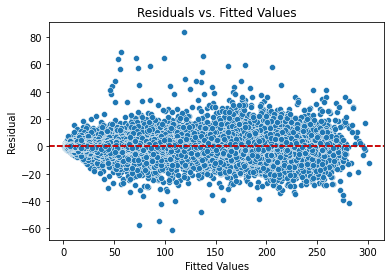

In [28]:
# Residuals vs Fitted Values
sns.scatterplot(data=validation, x='Prediction', y='Residual')
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(np.mean(validation['Residual']), color='red', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residual')
plt.title('Residuals vs. Fitted Values')
plt.show()

The mean of the resiudals is about zero and there is no apparent pattern in the Residuals vs. Fitted Values plot.

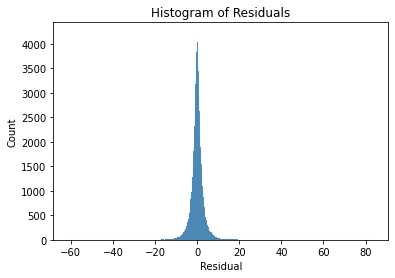

In [ ]:
# Histogram of Residuals
sns.histplot(data=validation, x='Residual')
plt.title('Histogram of Residuals')
plt.show()

The histogram of residuals has extreme values but appears mostly normally distributed.

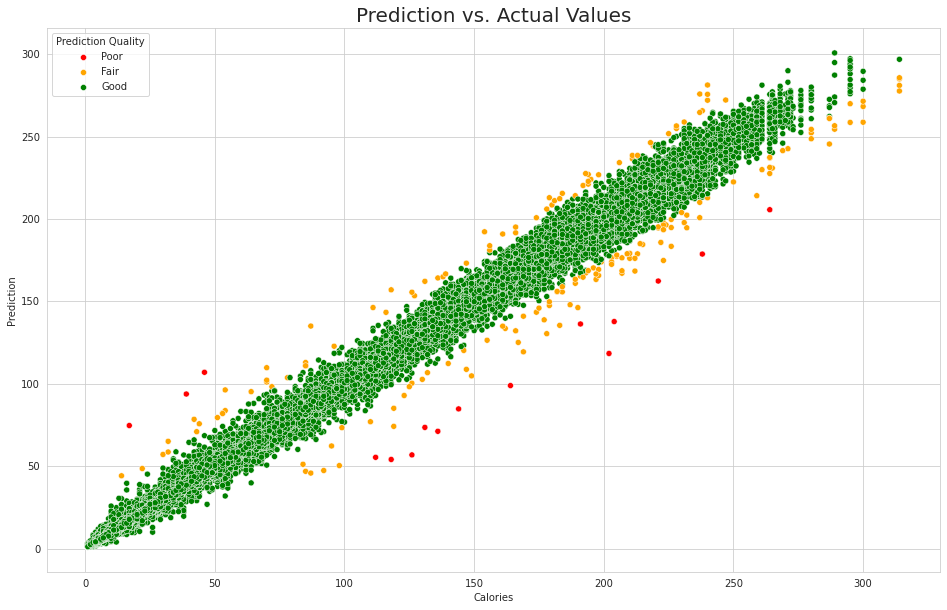

In [30]:
# Prediction vs. Actual
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(16, 10))
    sns.scatterplot(data=validation, x='Calories', y='Prediction', hue='Prediction Quality', hue_order=['Poor', 'Fair', 'Good'], palette=['red', 'orange', 'green'])
    plt.title('Prediction vs. Actual Values', fontsize=20)
    plt.show()

## Model Fitting

In [ ]:
# Fit the model to the training data
xgb_tuned.fit(X_train, y_train)

## Model Predictions

In [32]:
# Make predictions on the test data
pred = xgb_tuned.predict(X_test)

# Ensure all predictions are non-negative
pred = non_negative(pred)

# Add the predictions to the test data
test['Calories'] = pred
test.head()

,Sex,Male,Age,Senior,Weight,Height,BMI,max_HR,Heart_Rate,Relative_Intensity,...,Relative_Intensity*Body_Temp,Age*Heart_Rate,Senior*Male,Age*Body_Temp,Weight*Heart_Rate,Weight*Body_Temp,Age*Weight*Duration,Weight*Duration*Relative_Intensity,Age*Weight*Duration*Relative_Intensity,Calories
id,,,,,,,,,,,,,,,,,,,,,
750000,male,1,45,0,81.0,177.0,25.854639,176.5,87.0,0.492918,...,19.618130,3915.0,0,1791.0,7047.0,3223.8,25515.0,279.484419,12576.798867,27.555964
750001,male,1,26,0,97.0,200.0,24.250000,189.8,101.0,0.532139,...,21.551633,2626.0,0,1053.0,9797.0,3928.5,50440.0,1032.349842,26841.095890,107.840607
750002,female,0,29,0,85.0,188.0,24.049344,187.7,102.0,0.543420,...,21.954182,2958.0,0,1171.6,8670.0,3434.0,39440.0,739.051678,21432.498668,87.294403
750003,female,0,39,0,73.0,172.0,24.675500,180.7,107.0,0.592142,...,24.040952,4173.0,0,1583.4,7811.0,2963.8,56940.0,864.526840,33716.546763,125.998291
750004,female,0,30,0,67.0,173.0,22.386314,187.0,94.0,0.502674,...,20.358289,2820.0,0,1215.0,6298.0,2713.5,32160.0,538.866310,16165.989305,75.967712


In [33]:
pd.DataFrame({'feature':X_train.columns.values, 'importances':xgb_tuned.feature_importances_}).sort_values('importances', ascending=False)

,feature,importances
12,Duration*Relative_Intensity,0.584049
13,Duration*Heart_Rate,0.191278
14,Duration*Body_Temp,0.135150
9,Duration,0.063229
24,Weight*Duration*Relative_Intensity,0.006988
17,Relative_Intensity*Body_Temp,0.006970
7,Relative_Intensity,0.002605
0,Male,0.002278
16,Relative_Intensity*Weight,0.001726
19,Senior*Male,0.001406


The XGBoost model favours Duration*Relative_Intensity as its main predictor. Other Duration variables are also important to this model.

### Results

In [34]:
results = test[['Calories']]
results.head(15)

,Calories
id,
750000,27.555964
750001,107.840607
750002,87.294403
750003,125.998291
750004,75.967712
750005,21.520718
750006,48.446247
750007,6.808314
750008,10.053974


## Conclusion
Although this model was valuable for me in learning how to tune the hyperparameters of models, this model was not used in the final submission for the competition as it did not outperform the ensemble model.